In [85]:
import os
import random

import pandas as pd
import numpy as np

import pydicom as pyd
import matplotlib.pyplot as plt
import seaborn as sns


In [86]:
INPUT_PATH = 'E:/ICT/Dataset/rsna-intracranial-hemorrhage-detection/'

In [87]:
os.listdir(INPUT_PATH)

['stage_2_sample_submission.csv', 'stage_2_train.csv', 'test', 'train']

In [92]:
train_df = pd.read_csv(INPUT_PATH+"stage_2_train.csv")
train_df.head(5)

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0


In [ ]:
train_df.head(10)
labels = train_df['Label']

In [ ]:
train_df = train_df.ID.str.rsplit("_",n=1, expand = True)

In [ ]:
train_df.head(5)

,0,1
0,ID_12cadc6af,epidural
1,ID_12cadc6af,intraparenchymal
2,ID_12cadc6af,intraventricular
3,ID_12cadc6af,subarachnoid
4,ID_12cadc6af,subdural


In [ ]:
train_df['label'] = labels

In [ ]:
train_df.head(5)

,0,1,label
0,ID_12cadc6af,epidural,0
1,ID_12cadc6af,intraparenchymal,0
2,ID_12cadc6af,intraventricular,0
3,ID_12cadc6af,subarachnoid,0
4,ID_12cadc6af,subdural,0


In [ ]:
train_df = train_df.rename({0 : "image",1 : "subtype"}, axis=1)

In [ ]:
train_df.head(5)

,image,subtype,label
0,ID_12cadc6af,epidural,0
1,ID_12cadc6af,intraparenchymal,0
2,ID_12cadc6af,intraventricular,0
3,ID_12cadc6af,subarachnoid,0
4,ID_12cadc6af,subdural,0


In [ ]:
#Countts of targets for each subtype
subtype_count = train_df.groupby("subtype").label.value_counts().unstack()
subtype_count

label,0,1
subtype,,
any,644874,107933
epidural,749662,3145
intraparenchymal,716689,36118
intraventricular,726602,26205
subarachnoid,717132,35675
subdural,705641,47166


In [ ]:
#The % target distribution across each subtype
subtype_count_per =  subtype_count.loc[:,1]/train_df.groupby("subtype").size() *100

multi_target_count = train_df.groupby("image").label.sum()

In [ ]:
def random_colors(num_colors : int):
    colors = []
    for i in range(num_colors):
        colors.append('#'+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
    return colors 

C:\Users\sctha\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\sctha\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Imbalance in target distrubution')

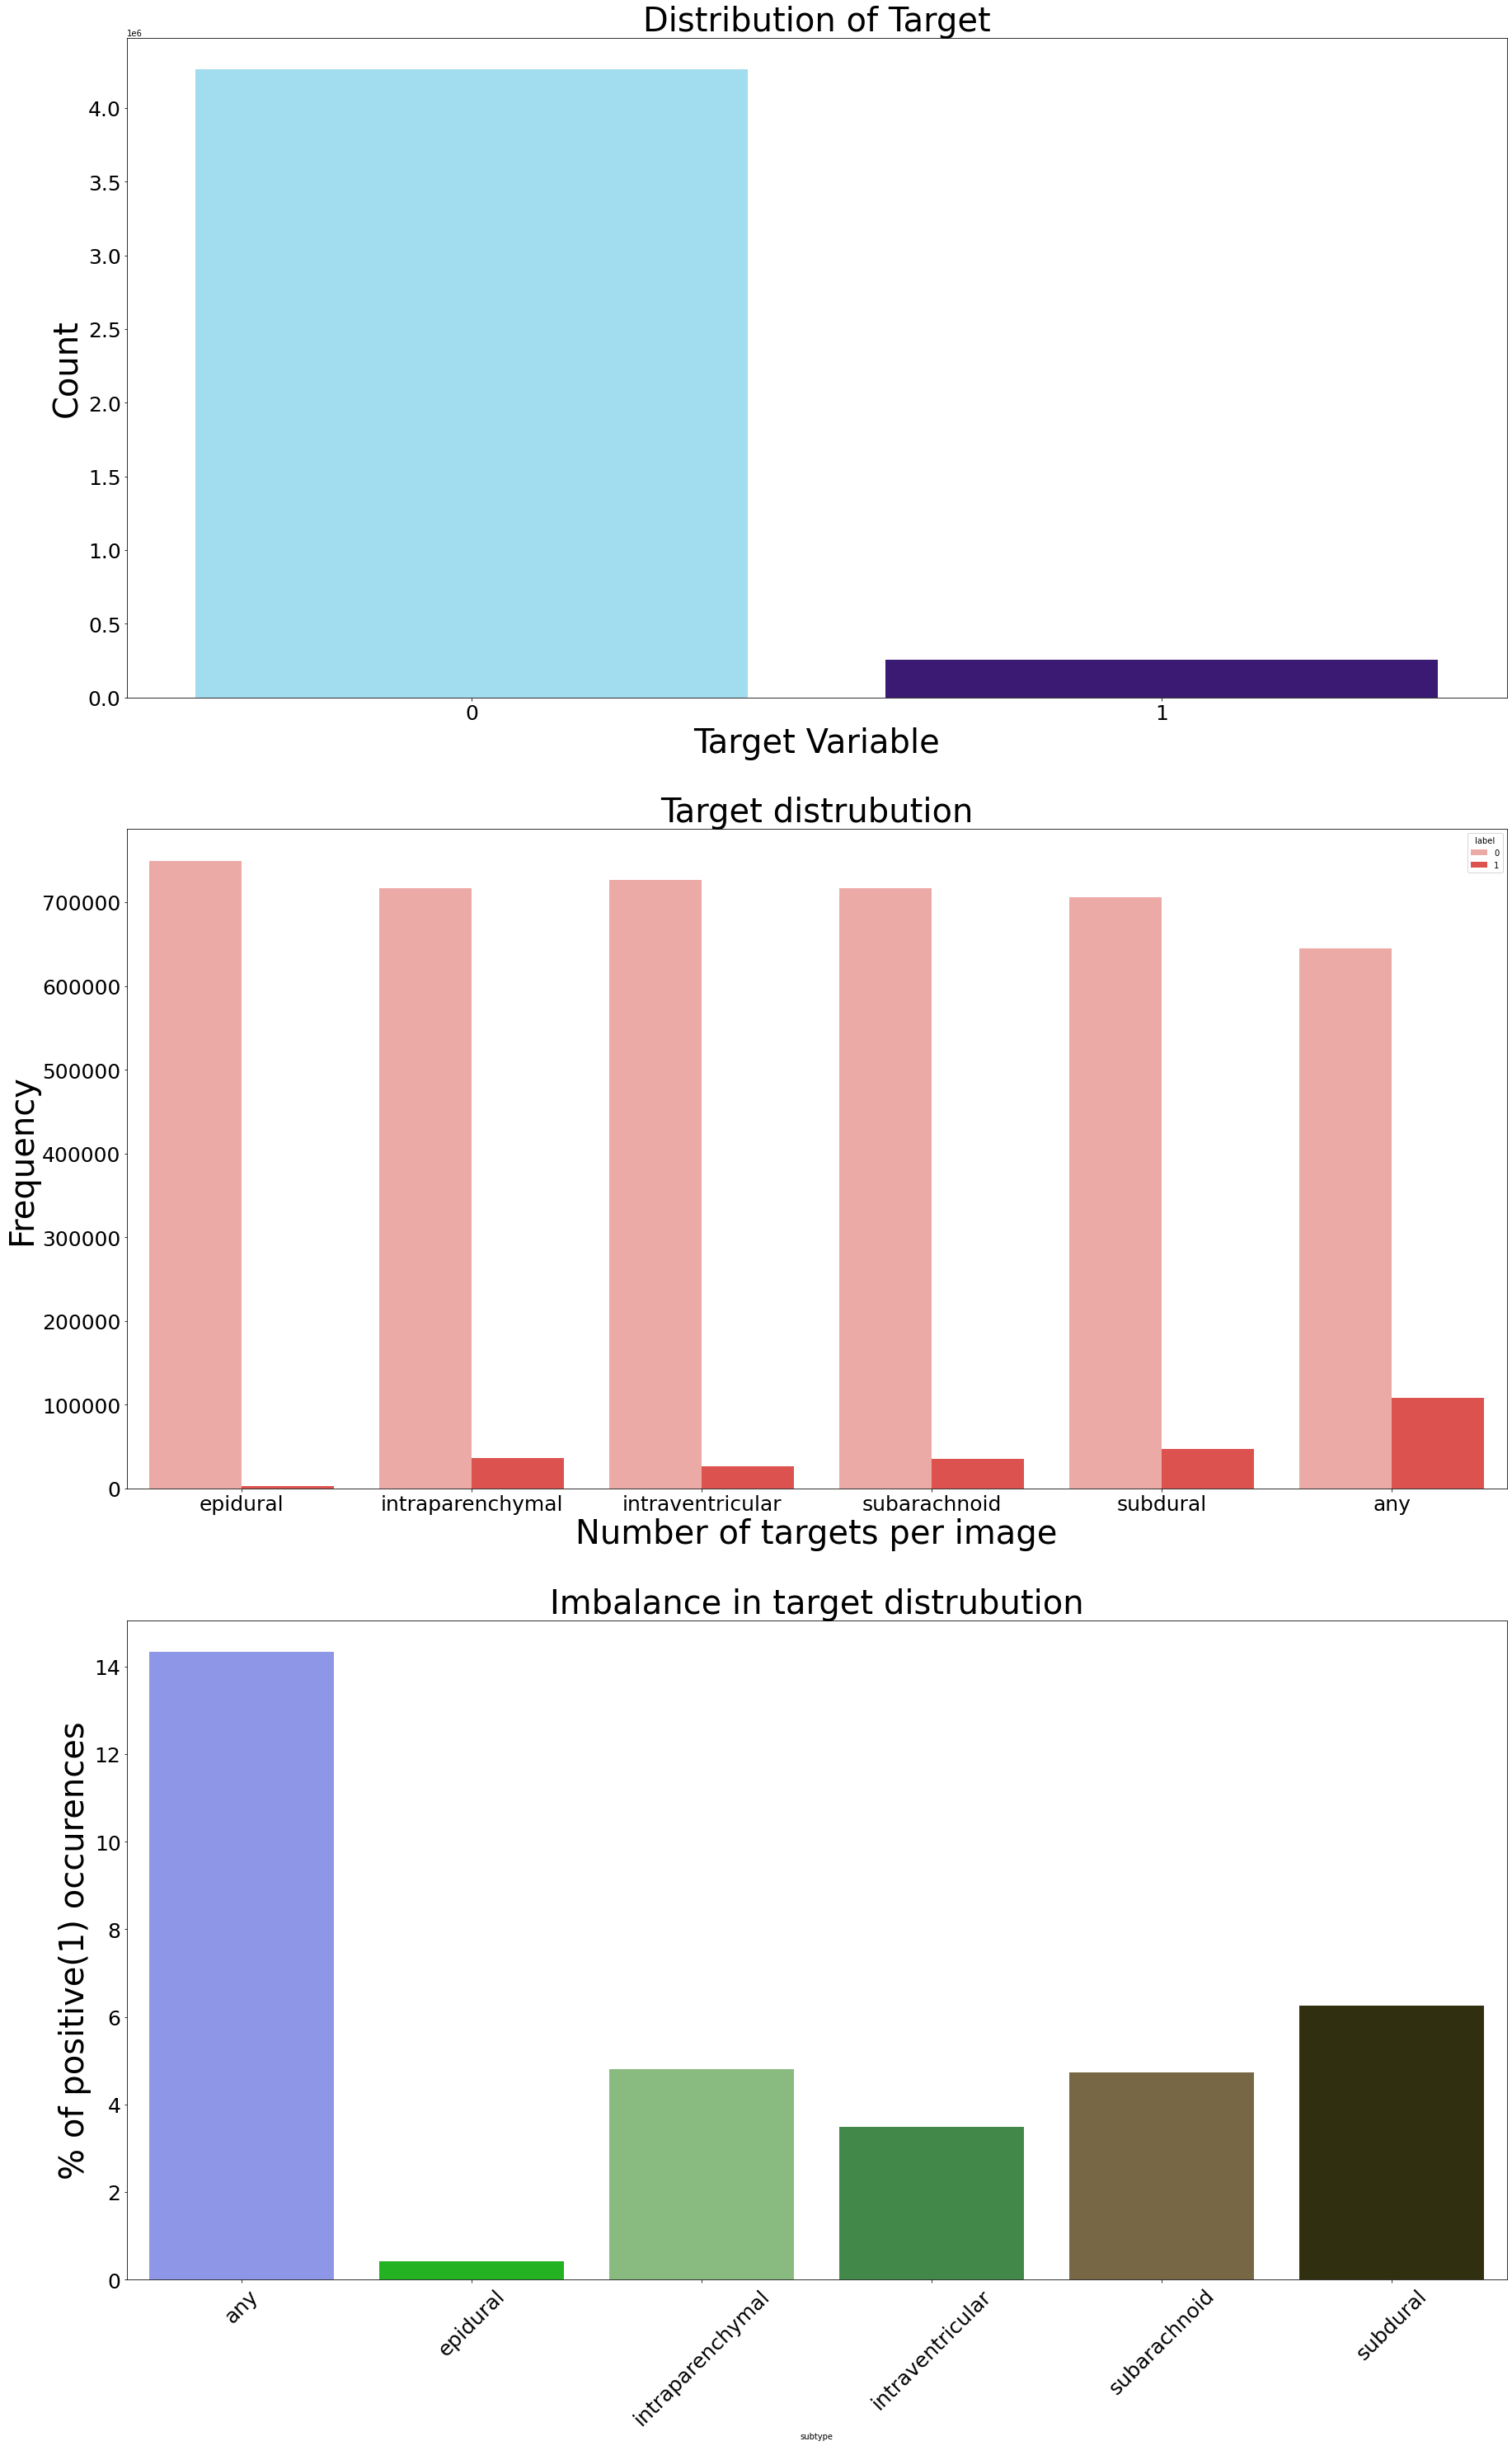

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(30,50))

sns.countplot(train_df.label,ax=ax[0], palette=random_colors(2))
ax[0].set_xlabel("Target Variable", fontsize=40)
ax[0].set_ylabel("Count", fontsize=40)
ax[0].tick_params(axis='x', labelsize=25 ) 
ax[0].tick_params(axis='y', labelsize=25 ) 
ax[0].set_title("Distribution of Target",fontsize=40)


sns.countplot(x="subtype", hue="label", data=train_df, ax=ax[1], palette=random_colors(6))
ax[1].set_xlabel("Number of targets per image",fontsize=40)
ax[1].set_ylabel("Frequency",fontsize=40)
ax[1].tick_params(axis='x', labelsize=25 ) 
ax[1].tick_params(axis='y', labelsize=25 ) 
ax[1].set_title("Target distrubution",fontsize=40)

sns.barplot(subtype_count_per.index, subtype_count_per.values, ax=ax[2], palette=random_colors(6))
plt.xticks(rotation=45)
ax[2].set_ylabel("% of positive(1) occurences",fontsize=40)
ax[2].tick_params(axis='x', labelsize=25 ) 
ax[2].tick_params(axis='y', labelsize=25 ) 
ax[2].set_title("Imbalance in target distrubution",fontsize=40)



In [ ]:
train_files = os.listdir(INPUT_PATH+"train")
len(train_files)

371832

In [ ]:
test_files = os.listdir(INPUT_PATH+"test")
len(test_files)

121232

In [ ]:
len(train_files)/len(test_files)
#Approx train = 3 * test, so we can say that the ratio of train to test image is 3:1, 75% to 25%

3.067110993797017

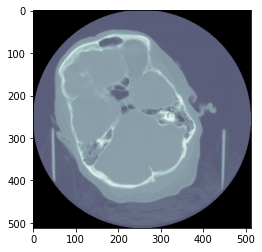

In [ ]:
dcm = pyd.dcmread(INPUT_PATH+"train/"+train_files[0])
plt.imshow(dcm.pixel_array,cmap = plt.cm.bone)

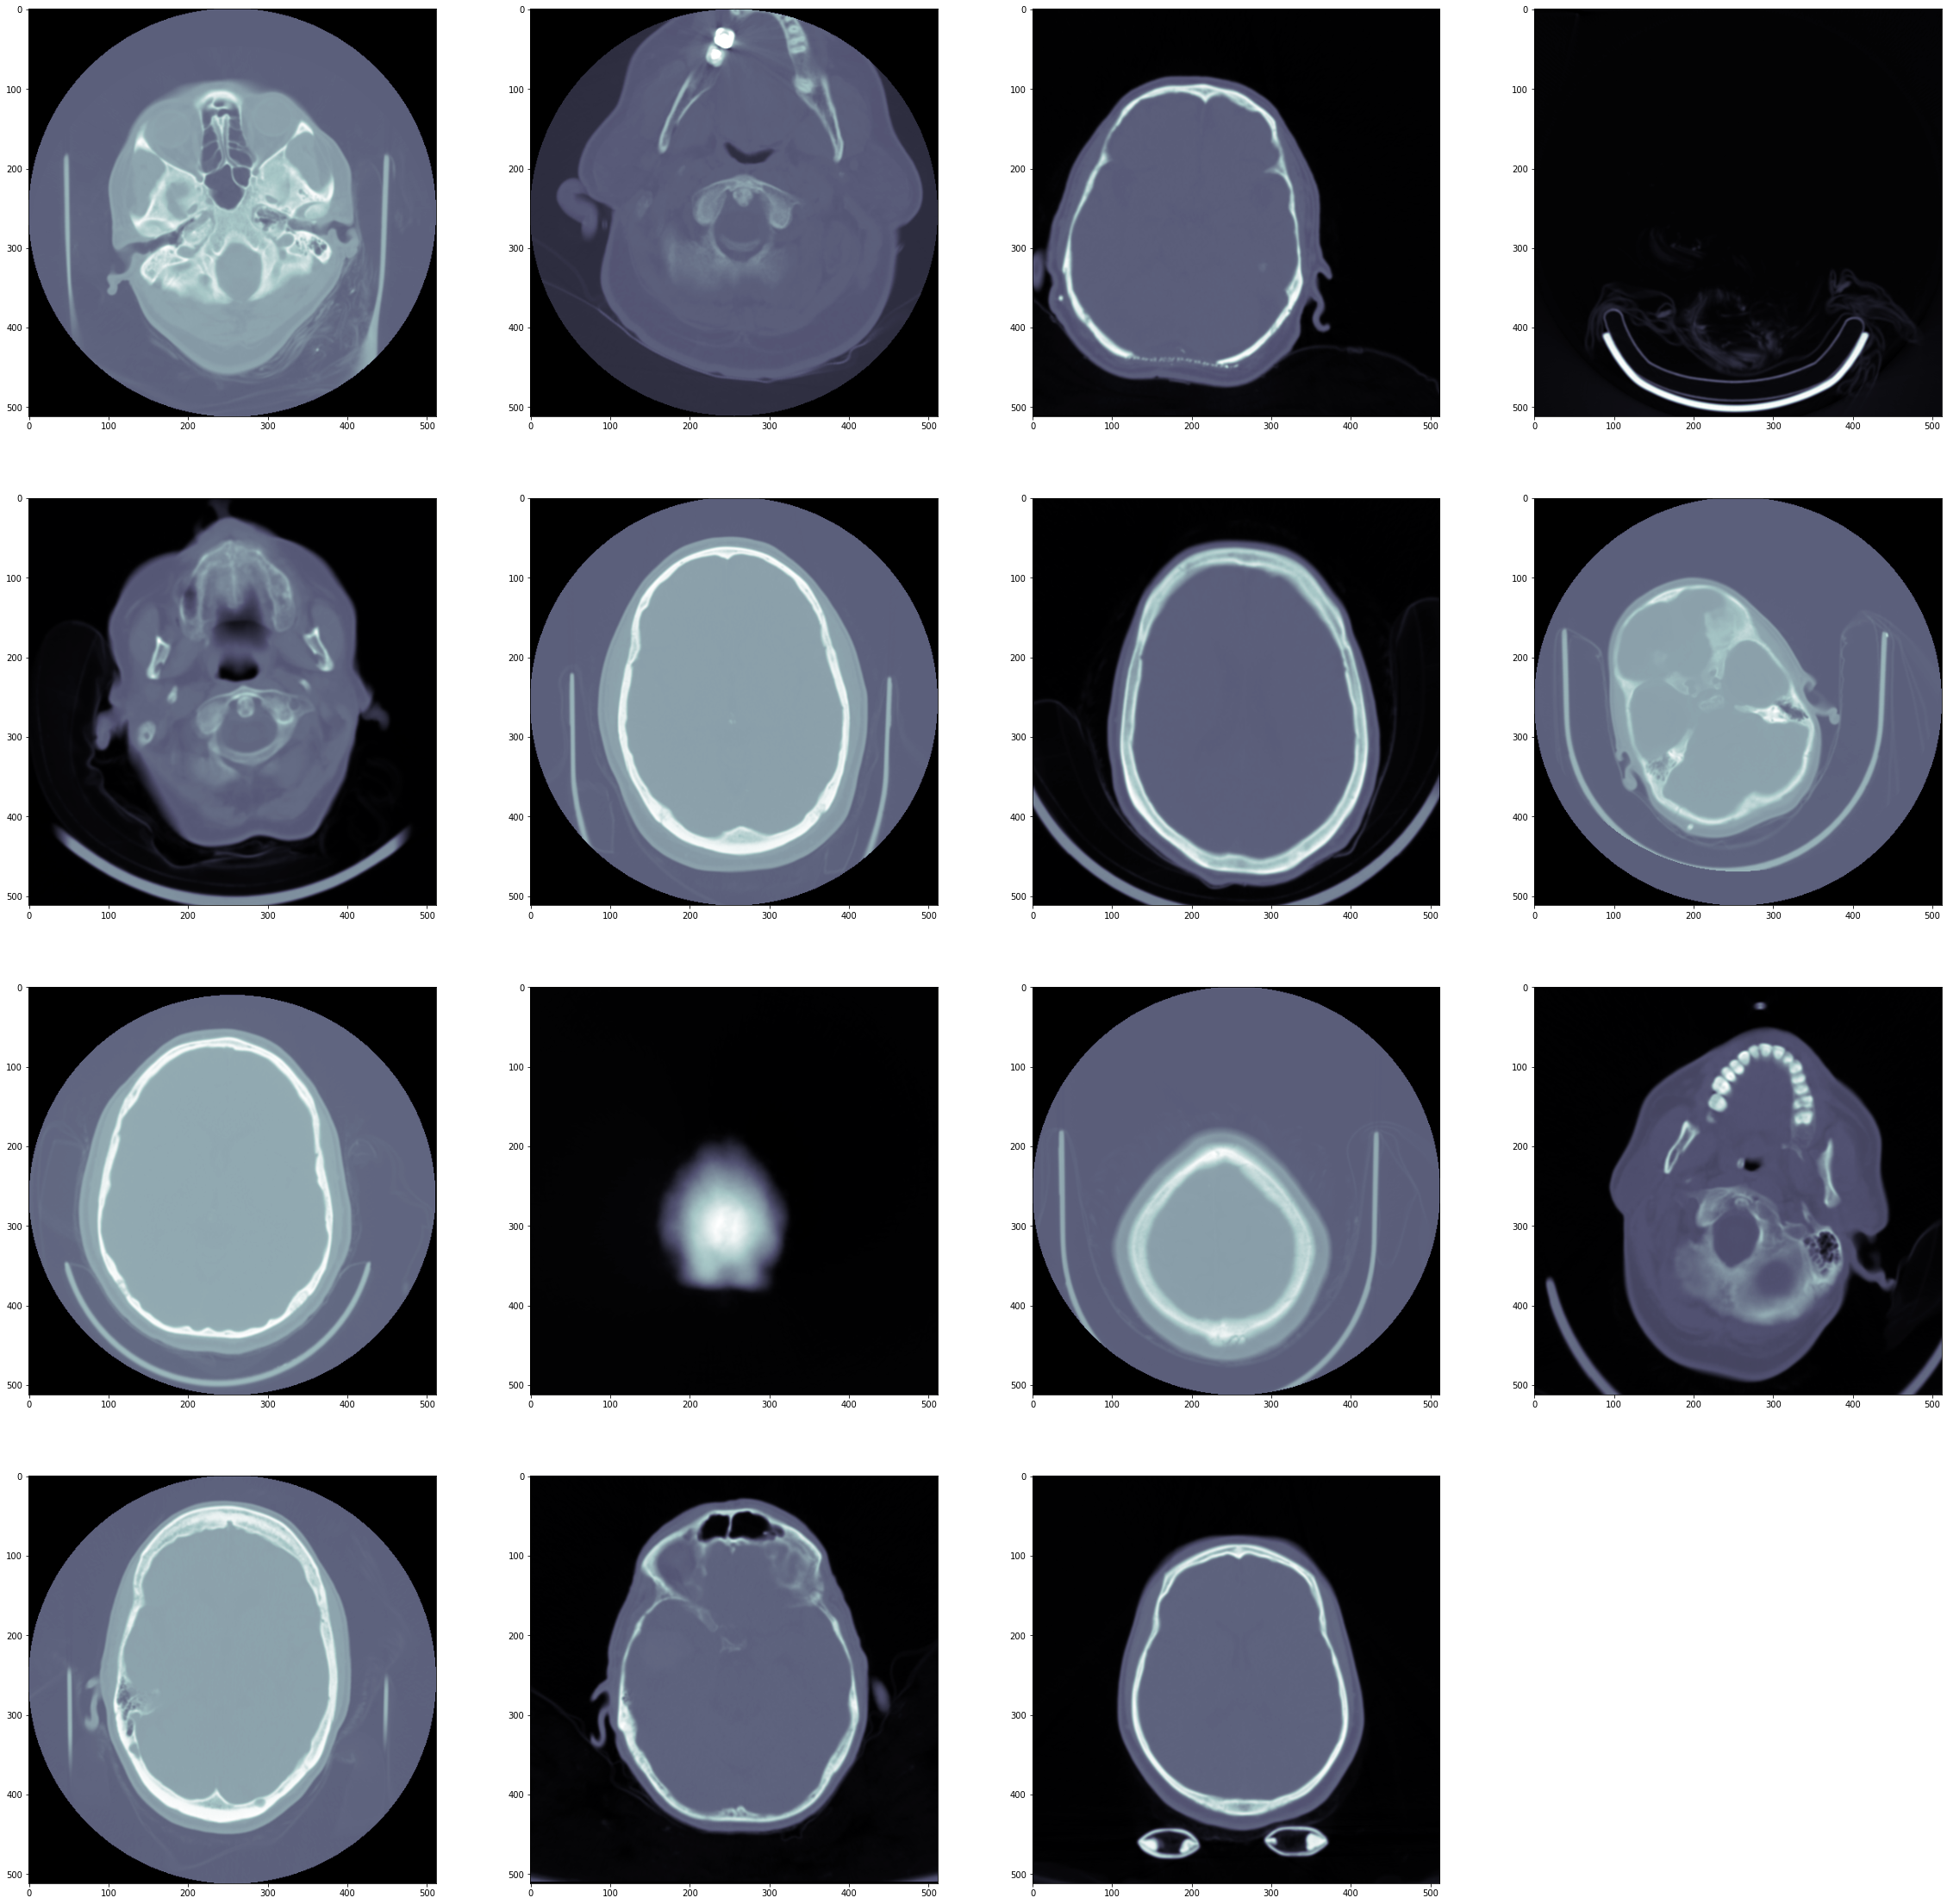

In [ ]:
a=4;b=4
fig = plt.figure(figsize=(40,40))
for i in range(1,a*b):
    dcm = pyd.dcmread(INPUT_PATH+"train/"+train_files[i])
    fig.add_subplot(a,b,i)
    plt.imshow(dcm.pixel_array,cmap=plt.cm.bone)

In [ ]:
TRAIN_PATH = INPUT_PATH+"train/"
TEST_PATH = INPUT_PATH+"test/"

In [ ]:
# A function to correct pixel data and rescale intercercepts ob 12 bit images
def dcm_correction(dcm_img):
        x = dcm_img.pixel_array + 1000
        px_mode = 4096
        x[x >= px_mode] = x[x >= px_mode] - px_mode #if there are extra bits in 12-bit grayscale(<=4096)
        dcm_img.PixelData = x.tobytes()
        dcm_img.RescaleIntercept = -1000 #setting a common value across all 12-bit US images

In [ ]:
def window_image(dcm, window_center, window_width):
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0):
        dcm_correction(dcm)

    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept #reconstructing the image from pixels
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img

In [90]:
TRAIN_PATH = INPUT_PATH+"train/"
TEST_PATH = INPUT_PATH+"test/"

def view_images(image, title=''):

    dcm = pyd.dcmread(os.path.join(TRAIN_PATH,image[0]+'.dcm'))

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(10,24))
    
    ax1.set_title("Default window")
    ax1.imshow(dcm.pixel_array, cmap=plt.cm.bone)
    
    ax2.set_title("Brain window")
    brain_img = window_image(dcm, 40, 80)
    ax2.imshow(brain_img, cmap=plt.cm.bone)
    
    ax3.set_title("Subdural window")
    subdural_img = window_image(dcm, 80, 200)
    ax3.imshow(subdural_img, cmap=plt.cm.bone)

    ax4.set_title("Soft Tissue window")
    soft_img = window_image(dcm, 40, 380)
    ax4.imshow(soft_img, cmap=plt.cm.bone)
    
    for ax in fig.axes:
        ax.axis("off")
        
    fig.suptitle(title)
    plt.show()

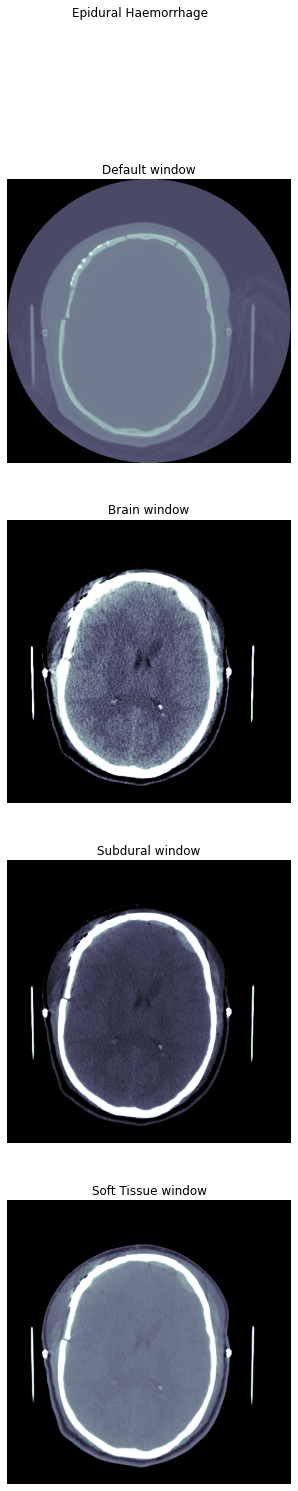

In [91]:
view_images(train_df[(train_df["subtype"] == 'epidural') & (train_df['label'] == 1)][:10].image.values, title='Epidural Haemorrhage')

In [ ]:
train_df[(train_df["subtype"] == 'epidural') & (train_df['label'] == 1)][:10].image.values

array(['ID_10c87b72a', 'ID_7c8a8e72b', 'ID_60f89ded6', 'ID_c0d0e2d2e',
       'ID_f0c01854e', 'ID_97cb48462', 'ID_03755d5a6', 'ID_ade010bbf',
       'ID_a1ff5f1f3', 'ID_7c6a28a0b'], dtype=object)